# CatBoostRegression Year column embedding    
    1. Year column embedding code to preserve time series properties.
    2. stock별 시계열패턴을 모델이 학습할수 있도록 작성된 코드.

In [1]:
import pandas as pd
from catboost import CatBoostRegressor

# CatBoost 다중 타겟: loss_function='MultiRMSE' 사용 (y shape: [n_samples, n_targets])
model = CatBoostRegressor(
    iterations=800,
    depth=8,
    learning_rate=0.06,
    loss_function='MultiRMSE',  # 다중 회귀 손실
    eval_metric='MultiRMSE',
    task_type='GPU',   # GPU 사용
    devices='0',
    boosting_type='Plain',
    random_seed=42,
    early_stopping_rounds=80,
    verbose=100
)
model


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "/home/super/anaconda3/envs/dh_catboost/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/home/super/anaconda3/envs/dh_catboost/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/home/super/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/super/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance
 

AttributeError: _ARRAY_API not found

In [2]:
# Set target_columns
target_columns = ['CETR', 'GETR', 'TSTA', 'TSDA']

In [3]:
# Load CSV file
df = pd.read_csv('data.csv')
df

,name,stock,year,KOSPI,fnd_year,fiscal,ind,big4,forn,own,...,GETR5,CETR5,TSTA,TSDA,A_GETR,A_CETR,A_GETR3,A_CETR3,A_GETR5,A_CETR5
0,동화약품,20,2013,1,1897,12,21,1,0.0613,0.3114,...,0.294414,0.266121,-0.071863,-0.088363,-0.236479,0.748503,0.058765,-0.096756,0.034497,-0.019779
1,동화약품,20,2014,1,1897,12,21,1,0.0502,0.3151,...,0.233461,0.418783,-0.001226,-0.014614,-0.150710,0.748503,0.500993,0.733432,-0.026455,0.132883
2,동화약품,20,2015,1,1897,12,21,1,0.0749,0.3235,...,0.231593,0.528209,0.072994,0.056283,-0.171420,-0.024525,-0.195255,0.733432,-0.028324,0.242310
3,동화약품,20,2016,1,1897,12,21,1,0.0746,0.3229,...,0.306044,0.325968,0.106756,0.107570,0.026917,-0.194237,-0.174602,0.327249,0.046128,0.040069
4,동화약품,20,2017,1,1897,12,21,1,0.1186,0.3240,...,0.250474,0.216419,-0.061506,0.008744,0.042469,-0.157749,-0.014648,-0.184860,-0.009442,-0.069481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12648,잉글우드랩,950140,2023,0,2015,12,20,0,0.1248,0.4408,...,0.174191,0.211668,-0.317902,-0.362904,-0.122071,0.080095,-0.064306,0.002523,0.001916,0.012473
12649,잉글우드랩,950140,2024,0,2015,12,20,0,0.1358,0.4408,...,0.114758,0.256242,-0.358287,-0.384294,-0.123269,0.292943,-0.129741,0.004858,-0.091928,0.027420
12650,고스트스튜디오,950190,2022,0,2016,12,58,1,0.1374,0.4427,...,0.176417,0.172354,-0.109588,-0.137899,-0.055951,-0.122758,-0.039628,0.121765,-0.064150,-0.092251
12651,고스트스튜디오,950190,2023,0,2016,12,58,1,0.1445,0.5158,...,0.180101,0.204584,-0.225762,-0.237668,-0.034687,-0.052817,-0.041439,-0.021230,-0.060466,-0.060022


In [4]:
# Set categorical_cols
categorical_cols = ['name', 'stock', 'KOSPI', 'big4', 'LOSS', 'ind']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print(df.dtypes)

name        category
stock       category
year           int64
KOSPI       category
fnd_year       int64
              ...   
A_CETR       float64
A_GETR3      float64
A_CETR3      float64
A_GETR5      float64
A_CETR5      float64
Length: 65, dtype: object


In [5]:
# 타겟 분리만 우선 수행 (피처 엔지니어링 이후 X 생성)
y = df[target_columns].copy()
# X 는 아래 시계열 인코딩 & lag 생성 후 구성
print('Targets shape:', y.shape)

Targets shape: (12653, 4)


In [6]:
# Time-series aware encoding & global cutoff split (2011~2023 train, 2024 test)
import numpy as np
from catboost import Pool
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

# 1. Year 기반 전역/종목별 트렌드 & 주기 인코딩
year_min = df['year'].min()
year_max = df['year'].max()

df['year_norm_global'] = (df['year'] - year_min) / (year_max - year_min)

df['year_index_stock'] = df.groupby('stock', observed=True)['year'].rank(method='dense').astype(int) - 1
df['year_norm_stock'] = df['year_index_stock'] / df.groupby('stock', observed=True)['year_index_stock'].transform('max')

angle = 2 * np.pi * df['year_norm_global']
df['year_sin'] = np.sin(angle)
df['year_cos'] = np.cos(angle)

# 2. Lag 특징 생성
exclude_for_lag = set(['name', 'stock', 'year'] + target_columns)
num_cols_for_lag = [c for c in df.columns if c not in exclude_for_lag and df[c].dtype.kind in ['i','u','f']]
for col in num_cols_for_lag:
    df[f'{col}_lag1'] = df.groupby('stock', observed=True)[col].shift(1)

# 3. 전역 컷오프 분리
CUTOFF_TEST_YEAR = 2024
train_mask = df['year'] < CUTOFF_TEST_YEAR
full_test_mask = df['year'] == CUTOFF_TEST_YEAR

train_df = df[train_mask].copy()
test_df = df[full_test_mask].copy()

# 4. 과거 기록 있는 종목만 테스트
seen_stocks = set(train_df['stock'].unique())
seen_test_df = test_df[test_df['stock'].isin(seen_stocks)].copy()

# 5. Feature / Target 분리
feature_drop = ['name', 'stock'] + target_columns
X_train = train_df.drop(columns=feature_drop)
X_test_seen = seen_test_df.drop(columns=feature_drop)
y_train = train_df[target_columns]
y_test_seen = seen_test_df[target_columns]

# 6. Lag 결측 처리
lag_cols = [c for c in X_train.columns if c.endswith('_lag1')]
if lag_cols:
    lag_medians = X_train[lag_cols].median()
    X_train[lag_cols] = X_train[lag_cols].fillna(lag_medians)
    X_test_seen[lag_cols] = X_test_seen[lag_cols].fillna(lag_medians)

# 7. CatBoost Pool 생성
# CatBoost는 카테고리형 피처 인덱스로 구분 (현재 X_train에서 category dtype 보존된 컬럼 찾기)
cat_feature_names = [c for c in X_train.columns if str(train_df[c].dtype) == 'category']
cat_feature_indices = [X_train.columns.get_loc(c) for c in cat_feature_names]

train_pool = Pool(data=X_train, label=y_train, cat_features=cat_feature_indices)
valid_pool = Pool(data=X_test_seen, label=y_test_seen, cat_features=cat_feature_indices)

print(f"Train years: {int(train_df['year'].min())}-{int(train_df['year'].max())} | Test year: {CUTOFF_TEST_YEAR}")
print(f"Seen stocks count: {len(seen_stocks)}")
print("Shapes -> Train:", X_train.shape, "SeenTest:", X_test_seen.shape)
print("Categorical features:", cat_feature_names)
print("Lag feature count:", len(lag_cols))
print("Sample feature cols:", X_train.columns[:12].tolist())

Train years: 2011-2023 | Test year: 2024
Seen stocks count: 1693
Shapes -> Train: (11567, 123) SeenTest: (1025, 123)
Categorical features: ['KOSPI', 'ind', 'big4', 'LOSS']
Lag feature count: 59
Sample feature cols: ['year', 'KOSPI', 'fnd_year', 'fiscal', 'ind', 'big4', 'forn', 'own', 'c_asset', 'inv', 'asset', 'sales']


In [7]:
# 7. 모델 학습 & 평가 (CatBoost Pool 사용)
model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

pred_seen = model.predict(valid_pool)  # shape: (n_samples, n_targets)
print('[Seen Stocks 2024] R2:', r2_score(y_test_seen, pred_seen),
      'MAE:', mean_absolute_error(y_test_seen, pred_seen),
      'RMSE:', root_mean_squared_error(y_test_seen, pred_seen))

# 타겟별 상세
print('\nPer-target metrics:')
for i, col in enumerate(target_columns):
    r2_i = r2_score(y_test_seen[col], pred_seen[:, i])
    mae_i = mean_absolute_error(y_test_seen[col], pred_seen[:, i])
    rmse_i = root_mean_squared_error(y_test_seen[col], pred_seen[:, i])
    print(f"  {col}: R2={r2_i:.4f} MAE={mae_i:.4f} RMSE={rmse_i:.4f}")

# importance
fi = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print('\nTop 25 Feature Importances:')
print(fi.head(25))

0:	learn: 0.4726222	test: 0.4671008	best: 0.4671008 (0)	total: 26.7ms	remaining: 21.3s
100:	learn: 0.1187140	test: 0.1304833	best: 0.1304833 (100)	total: 1.71s	remaining: 11.9s
200:	learn: 0.0934494	test: 0.1175563	best: 0.1175563 (200)	total: 3.45s	remaining: 10.3s
300:	learn: 0.0791924	test: 0.1120801	best: 0.1120801 (300)	total: 5.23s	remaining: 8.67s
400:	learn: 0.0682419	test: 0.1087829	best: 0.1087829 (400)	total: 6.99s	remaining: 6.95s
500:	learn: 0.0605647	test: 0.1063552	best: 0.1063552 (500)	total: 8.69s	remaining: 5.18s
600:	learn: 0.0540481	test: 0.1046634	best: 0.1046621 (599)	total: 10.4s	remaining: 3.44s
700:	learn: 0.0484951	test: 0.1031287	best: 0.1031287 (700)	total: 12s	remaining: 1.7s
799:	learn: 0.0437152	test: 0.1020858	best: 0.1020858 (799)	total: 13.7s	remaining: 0us
bestTest = 0.102085784
bestIteration = 799
[Seen Stocks 2024] R2: 0.9604781569778786 MAE: 0.02722956942995304 RMSE: 0.045367854675200624

Per-target metrics:
  CETR: R2=0.9900 MAE=0.0163 RMSE=0.0225

            R2       MAE      RMSE
CETR  0.989992  0.016334  0.022529
GETR  0.974845  0.015538  0.021483
TSTA  0.940473  0.037351  0.067157
TSDA  0.936602  0.039696  0.070302


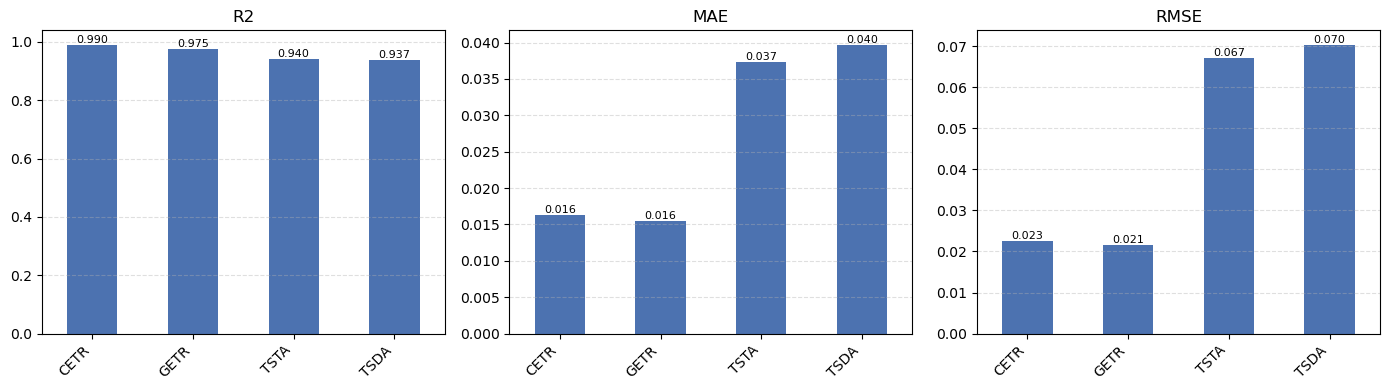

In [8]:
import matplotlib.pyplot as plt

# 타겟별 성능지표 계산
metrics = {'R2': [], 'MAE': [], 'RMSE': []}
for i, col in enumerate(target_columns):
    y_true = y_test_seen[col]
    y_pred = pred_seen[:, i]
    metrics['R2'].append(r2_score(y_true, y_pred))
    metrics['MAE'].append(mean_absolute_error(y_true, y_pred))
    metrics['RMSE'].append(root_mean_squared_error(y_true, y_pred))

metrics_df = pd.DataFrame(metrics, index=target_columns)
print(metrics_df)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, metric in zip(axes, metrics_df.columns):
    axes_idx = metrics_df[metric].plot(kind='bar', ax=ax, color='#4C72B0')
    ax.set_title(metric)
    ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    for p in ax.patches:
        val = p.get_height()
        ax.annotate(f'{val:.3f}', (p.get_x() + p.get_width()/2, val),
                    ha='center', va='bottom', fontsize=8, rotation=0)
plt.tight_layout()
plt.show()

In [10]:
# 8. 결과 저장 (Seen test)
import numpy as np
results_df = pd.DataFrame(
    data = np.hstack([y_test_seen.values, pred_seen]),
    columns = [f'actual_{col}' for col in y_test_seen.columns] + [f'pred_{col}' for col in y_test_seen.columns],
    index = y_test_seen.index,
)
results_df.to_csv('actual_vs_predicted_seen_2024_catboost.csv', index=True)
print('Saved: actual_vs_predicted_seen_2024_catboost.csv')

# Per-target metrics 저장
metric_rows = []
for i, col in enumerate(target_columns):
    metric_rows.append({
        'target': col,
        'R2': r2_score(y_test_seen[col], pred_seen[:, i]),
        'MAE': mean_absolute_error(y_test_seen[col], pred_seen[:, i]),
        'RMSE': root_mean_squared_error(y_test_seen[col], pred_seen[:, i])
    })
metrics_df = pd.DataFrame(metric_rows)
metrics_df.to_csv('CatBoost_metrics_seen_2024.csv', index=False)
print('Saved: CatBoost_metrics_seen_2024.csv')

Saved: actual_vs_predicted_seen_2024_catboost.csv
Saved: CatBoost_metrics_seen_2024.csv


## Reference site
    지표 및 점수
    https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation
    https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
